Import necassary libraries:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, BooleanType
from IPython.display import display, clear_output
import time

Setup connection and subscribed to the twitterdata topic:

In [2]:
# Open spark session
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

# Subscribed to twitterdata topic
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "twitterdata") \
  .load()

Convert the value column to string, then convert the JSON string to StructType *(online including the columns we are interested in)*:

In [3]:
string_stream_df = stream_df.withColumn("value", stream_df["value"].cast(StringType()))
tweet_schema = StructType([
    StructField('created_at', StringType(), True),
    StructField('id', LongType(), True),
    StructField('text', StringType(), True),
    StructField('is_quote_status', BooleanType(), True),
    StructField('in_reply_to_user_id', LongType(), True),
    StructField('user', StructType([
        StructField('id', LongType(), True),
        StructField('followers_count', IntegerType(), True),
        StructField('friends_count', IntegerType(), True),
        StructField('created_at', StringType(), True)
    ])),
    StructField('extended_tweet', StructType([
        StructField('full_text', StringType(), True)
    ])),
    StructField('retweeted_status', StructType([
        StructField('id', LongType(), True),
        StructField('extended_tweet', StructType([
            StructField('full_text', StringType(), True)
        ]))
    ])),
    StructField('retweet_count', IntegerType(), True),
    StructField('favorite_count', IntegerType(), True),
    StructField('quote_count', IntegerType(), True),
    StructField('reply_count', IntegerType(), True)
])
struct_stream_df = string_stream_df.withColumn("value", F.from_json("value", tweet_schema))

Select the columns we want to persist to Parquet:

In [4]:
def get_pattern(value):
    return f'(?i)({value})'

twitter_extended_df = struct_stream_df.select(
    'timestamp'
    , 'value.created_at'
    , 'value.id'
    , 'value.text'
    , 'value.is_quote_status'
    , 'value.in_reply_to_user_id'
    , F.col('value.user.id').alias('user_id')
    , F.col('value.user.followers_count').alias('user_followers_count')
    , F.col('value.user.friends_count').alias('user_friends_count')
    , F.col('value.user.created_at').alias('user_created_at')
    , F.col('value.extended_tweet.full_text').alias('extended_full_text')
    , F.col('value.retweeted_status.extended_tweet.full_text').alias('retweet_extended_full_text')
    , F.col('value.retweeted_status.id').alias('retweeted_status_id')
    , 'value.retweet_count'
    , 'value.favorite_count'
    , 'value.quote_count'
    , 'value.reply_count'
).withColumn(
    'combined_text'
    , F.concat_ws(' ', F.col('text'), F.col('retweet_extended_full_text'), F.col('extended_full_text'))
).withColumn(
    'category'
    , F.when(F.col('combined_text').rlike(get_pattern('cryptocurrency')), 'cryptocurrency') \
        .when(F.col('combined_text').rlike(get_pattern('crypto')), 'crypto') \
        .when(F.col('combined_text').rlike(get_pattern('binance')), 'binance') \
        .when(F.col('combined_text').rlike(get_pattern('coinbase')), 'coinbase') \
        .when(F.col('combined_text').rlike(get_pattern('coinmarketcap')), 'coinmarketcap') \
        .when(F.col('combined_text').rlike(get_pattern('musk')), 'musk') \
        .when(F.col('combined_text').rlike(get_pattern('memecoin')), 'memecoin') \
        .when(F.col('combined_text').rlike(get_pattern('shitcoin')), 'shitcoin') \
        .when(F.col('combined_text').rlike(get_pattern('moon')), 'moon') \
        .when(F.col('combined_text').rlike(get_pattern('hodl')), 'hodl') \
        .when(F.col('combined_text').rlike(get_pattern('fud')), 'fud') \
        .when(F.col('combined_text').rlike(get_pattern('bitcoin')), 'bitcoin') \
        .when(F.col('combined_text').rlike(get_pattern('btc')), 'btc') \
        .when(F.col('combined_text').rlike(get_pattern('ethereum')), 'ethereum') \
        .when(F.col('combined_text').rlike(get_pattern('ether')), 'ether') \
        .when(F.col('combined_text').rlike(get_pattern('gwei')), 'gwei') \
        .when(F.col('combined_text').rlike(get_pattern('vitalik buterin')), 'vitalik buterin') \
        .when(F.col('combined_text').rlike(get_pattern('gavin wood')), 'gavin wood') \
        .when(F.col('combined_text').rlike(get_pattern('erc20')), 'erc20') \
        .when(F.col('combined_text').rlike(get_pattern('dogecoin')), 'dogecoin') \
        .when(F.col('combined_text').rlike(get_pattern('doge')), 'doge') \
        .when(F.col('combined_text').rlike(get_pattern('billy markus')), 'billy markus') \
        .when(F.col('combined_text').rlike(get_pattern('jackson palmer')), 'jackson palmer') \
        .when(F.col('combined_text').rlike(get_pattern('pancakeswap')), 'pancakeswap') \
        .when(F.col('combined_text').rlike(get_pattern('cake')), 'cake') \
        .when(F.col('combined_text').rlike(get_pattern('swap')), 'swap') \
        .when(F.col('combined_text').rlike(get_pattern('eth')), 'eth')
).withColumn(
    'is_retweet'
    , F.isnull(F.col('retweeted_status_id')) != True
)

Start streaming to parquet:

In [5]:
flat_stream_out_extended = twitter_extended_df \
    .writeStream \
    .outputMode("append") \
    .option('path', 'data/twitter_flat_extended.parquet') \
    .option("checkpointLocation", "data/twitter_flat_extended.checkpoint") \
    .start()

Let that run for a while then stop the stream with the below cell:

In [6]:
flat_stream_out_extended.stop()

Lets take  quick look at the data captured:

In [7]:
df = spark.read.parquet('data/twitter_flat_extended.parquet')
df.show()

+--------------------+--------------------+-------------------+--------------------+---------------+-------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------------+-------------------+-------------+--------------+-----------+-----------+--------------------+--------------+----------+
|           timestamp|          created_at|                 id|                text|is_quote_status|in_reply_to_user_id|            user_id|user_followers_count|user_friends_count|     user_created_at|  extended_full_text|retweet_extended_full_text|retweeted_status_id|retweet_count|favorite_count|quote_count|reply_count|       combined_text|      category|is_retweet|
+--------------------+--------------------+-------------------+--------------------+---------------+-------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------------+-----------

What fraction of the tweets we received don't match up to the keywords we specified in the filter:

In [8]:
total = df.count()
total_null = df.filter(F.isnull(F.col('category'))).count()
print(f'Null category fraction: {total_null / total}')

Null category fraction: 0.06228316537254254


With the filter we are applying to the twitter streaming API, roughly 10% of the tweets we received don't match up to the keywords, when I remove 'eth' and 'ether' this does tend to drop a little to roughly 6%, so using a wordcloud lets take a highlevel view of what the themes are in these tweets.

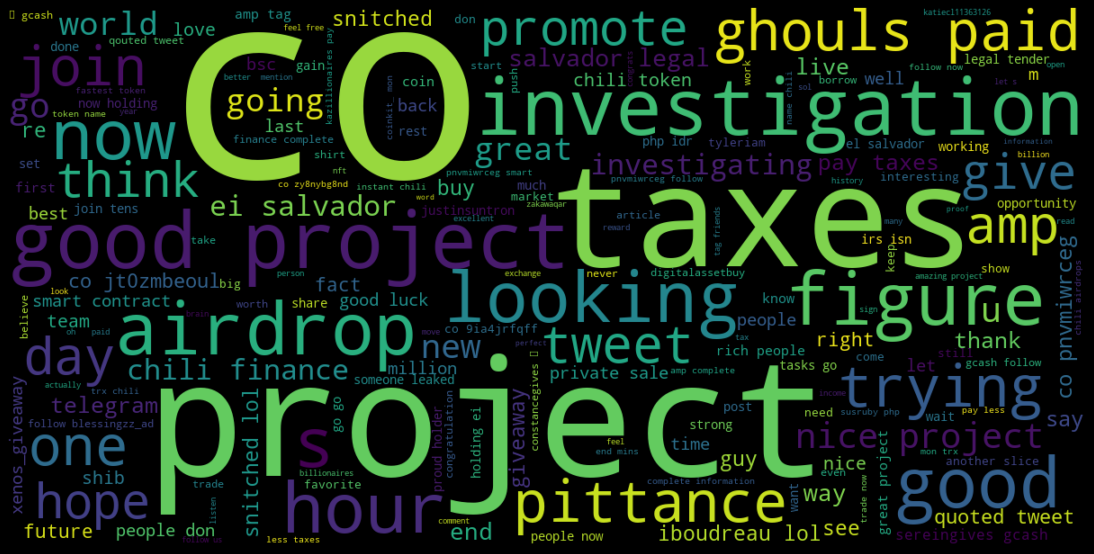

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

null_df = df.filter(F.isnull(F.col('category')))

text = ' '.join(list(null_df.toPandas().combined_text)).lower()
cloud = WordCloud(
    stopwords=STOPWORDS.union(['will', 'wow', 'https', 'rt', 't', 'retweet'])
    , width=1200, height=600
).generate(text)
plt.figure(figsize=(15,8), facecolor='k')
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Close the spark session:

In [33]:
spark.stop()